<a href="https://colab.research.google.com/github/young-scientific-researcher/Neurodegeneration/blob/main/segmentation_proj_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### TEST white-top-hat filter for background removal (skimage.morphology) disk size (footprint)= cell diam https://biapol.github.io/Image-data-science-with-Python-and-Napari-EPFL2022/day2c_Image_Filters/09_Filters.html

### Difference-of-Gaussian (DoG)

### The Laplace-filter is frequently used to detect edges (e Mexican-hat-filter)

### from napari_simpleitk_image_processing import threshold_otsu, touching_objects_labeling

### https://biapol.github.io/Image-data-science-with-Python-and-Napari-EPFL2022/day2d_image_segmentation/11_voronoi_otsu_labeling.html

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
import numpy as np
import time, os, sys
import cv2
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL
import torch
from skimage.io import imread, imshow
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import gaussian, sobel
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.morphology import binary_opening
from skimage.feature import canny
%matplotlib inline
mpl.rcParams['figure.dpi'] = 70
import cellpose
from urllib.parse import urlparse
from cellpose import models, core
from cellpose import utils
from cellpose import plot
from cellpose import io


# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup()

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.7/45.7 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 173.5/173.5 kB 4.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

(<Logger cellpose.io (WARNING)>, PosixPath('/root/.cellpose/run.log'))

In [ ]:
!pip install napari
import napari

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.6/2.6 MB 25.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 59.2/59.2 kB 8.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123.9/123.9 kB 16.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 93.9/93.9 kB 12.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61.7/61.7 kB 7.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 294.0/294.0 kB 34.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
!pip install napari_simpleitk_image_processing
from napari_simpleitk_image_processing import threshold_otsu, touching_objects_labeling

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 52.7/52.7 MB 33.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 319.0/319.0 kB 34.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.5/62.5 kB 7.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 307.2/307.2 kB 32.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 255.7/255.7 kB 29.2 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.3/45.3 kB 6.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/napari_tools_menu/__init__.py:10: UserWarning: Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.
  warnings.warn("Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.")
/usr/local/lib/python3.10/dist-packages/napari_tools_menu/__init__.py:221: UserWarning: Error in monkey patching napari. Please let @haesleinleinhuepf know at
https://github.com/haesleinhuepf/napari-tools-menu/issues
  warnings.warn("Error in monkey patching napari. Please let @haesleinleinhuepf know at\nhttps://github.com/haesleinhuepf/napari-tools-menu/issues")
/usr/local/lib/python3.10/dist-packages/napari_skimage_regionprops/_table.py:7: UserWarning: No Qt bindings could be found
  warnings.warn(str(e))


In [ ]:
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

>>> GPU activated? 1


## Path to images in 1 z stack

In [ ]:
z_stack_path_input = '/content/drive/MyDrive/cellpose/Alz/input/z_st_2/'

## Open images

In [ ]:
paths_to_dapi = []
paths_to_neun = []
for filename in os.listdir(z_stack_path_input):
  f = os.path.join(z_stack_path_input, filename)

  if 'dapi.tif' in filename.lower():
    paths_to_dapi.append(f)
  # elif 'gfp.tif' in filename.lower():
  #   paths_to_neun.append(f)
paths_to_dapi.sort(key=lambda x: int(os.path.basename(x).split('.')[0][11:14]))

dapi_imgs = [cv2.imread(f, 0) for f in paths_to_dapi]
# neun_imgs = [cv2.imread(f, 0) for f in paths_to_neun]

In [ ]:
before_filter_stack = np.stack(dapi_imgs, axis = 0)
before_filter_stack = np.moveaxis(before_filter_stack, 0, -1)
before_filter_stack.shape

(1024, 1024, 176)

In [ ]:
before_filter_stack_l = []
for i in range(before_filter_stack.shape[2]):
  img = before_filter_stack_l.append(PIL.Image.fromarray(before_filter_stack[:,:,i]))
before_filter_stack_l[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/before_filter_stack.tif', compression="tiff_deflate", save_all=True,
               append_images=before_filter_stack_l[1:])

## Filter dapi images

In [ ]:
filtered_dapi = []

for i in dapi_imgs:
  cr_clahe = cv2.createCLAHE(10,(20, 20))
  cl = cr_clahe.apply(i)
  blured = cv2.bilateralFilter(cl, 10, 20, 20)
  _, th = cv2.threshold(blured,60, 255, cv2.THRESH_TRUNC)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  erode = cv2.erode(th,kernel,iterations = 1)
  cr_clahe2 = cv2.createCLAHE(10,(30, 30))

  cl2 = cr_clahe2.apply(erode)
  blur = cv2.bilateralFilter(cl2,8,20,20)
  closing = cv2.morphologyEx(cl2, cv2.MORPH_CLOSE, kernel, 3)
  # opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, 1)

  filtered_dapi.append(blur[200:800, 200:800])

## Make a dapi stack

In [ ]:
raw_stack = np.stack(filtered_dapi, axis = 0)
raw_stack = np.moveaxis(raw_stack, 0, -1)
raw_stack.shape

(600, 600, 176)

## Save dapi stack as tiff

In [ ]:
raw_stack_l = []
for i in range(raw_stack.shape[2]):
  img = raw_stack_l.append(PIL.Image.fromarray(raw_stack[:,:,i]))
raw_stack_l[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/raw_stack.tif', compression="tiff_deflate", save_all=True,
               append_images=raw_stack_l[1:])

## 3D cellpose for dapi stack

In [ ]:
model_3d = models.Cellpose(gpu = True, model_type='cyto', net_avg = False, device = torch.device('cuda'))
channels = [0,0]
diameter_dapi = 44

masks_3d, flows_3d, styles_3d, diams_3d = model_3d.eval(raw_stack, invert = True, diameter= diameter_dapi, do_3D = True, channels=channels, progress = True)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25.3M/25.3M [00:02<00:00, 11.0MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.23k/5.23k [00:00<00:00, 7.37MB/s]


## Save masks

In [ ]:
io.masks_flows_to_seg(raw_stack, masks_3d, flows_3d, diams_3d, '/content/drive/MyDrive/cellpose/Alz/input/raw_stack/raw_stack.tif', channels)

## Open masks

In [ ]:
# working from home L
# mask_3d_lisa = np.load('/content/drive/MyDrive/–ö–æ–ø–∏—è raw_stack_seg.npy', allow_pickle = True).item()['masks']

In [ ]:
mask_3d = np.load('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/raw_stack_seg.npy', allow_pickle = True).item()['masks']

In [ ]:
mask_3d.shape


(600, 600, 176)

In [ ]:
stack_3d = []
for i in range(mask_3d.shape[2]):
  img = stack_3d.append(PIL.Image.fromarray(mask_3d[:,:,i]))
stack_3d[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/stack_after_cellpose_3d_net_evg_false.tif', compression="tiff_deflate", save_all=True,
               append_images=stack_3d[1:])


## Process 3D dapi masks // watershaed


In [ ]:
masks_to_2d = []
for i in range(mask_3d.shape[2]):
  masks_to_2d.append(mask_3d[:,:,i])

In [ ]:
masks_2d_bin = []
for i in masks_to_2d:
  _, bin = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY)
  masks_2d_bin.append(bin)

In [ ]:
stack_binary = np.stack(masks_2d_bin, axis = 0)
stack_binary = np.moveaxis(stack_binary, 0, -1)

stack_binary.shape

(600, 600, 176)

In [ ]:
stack_3d_binary = []
for i in range(stack_binary.shape[2]):
  img = stack_3d_binary.append(PIL.Image.fromarray(stack_binary[:,:,i]))
stack_3d_binary[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/stack_after_cellpose_3d_binary.tif', compression="tiff_deflate", save_all=True,
               append_images=stack_3d_binary[1:])

Text(0.5, 1.0, 'new_masks_binary')

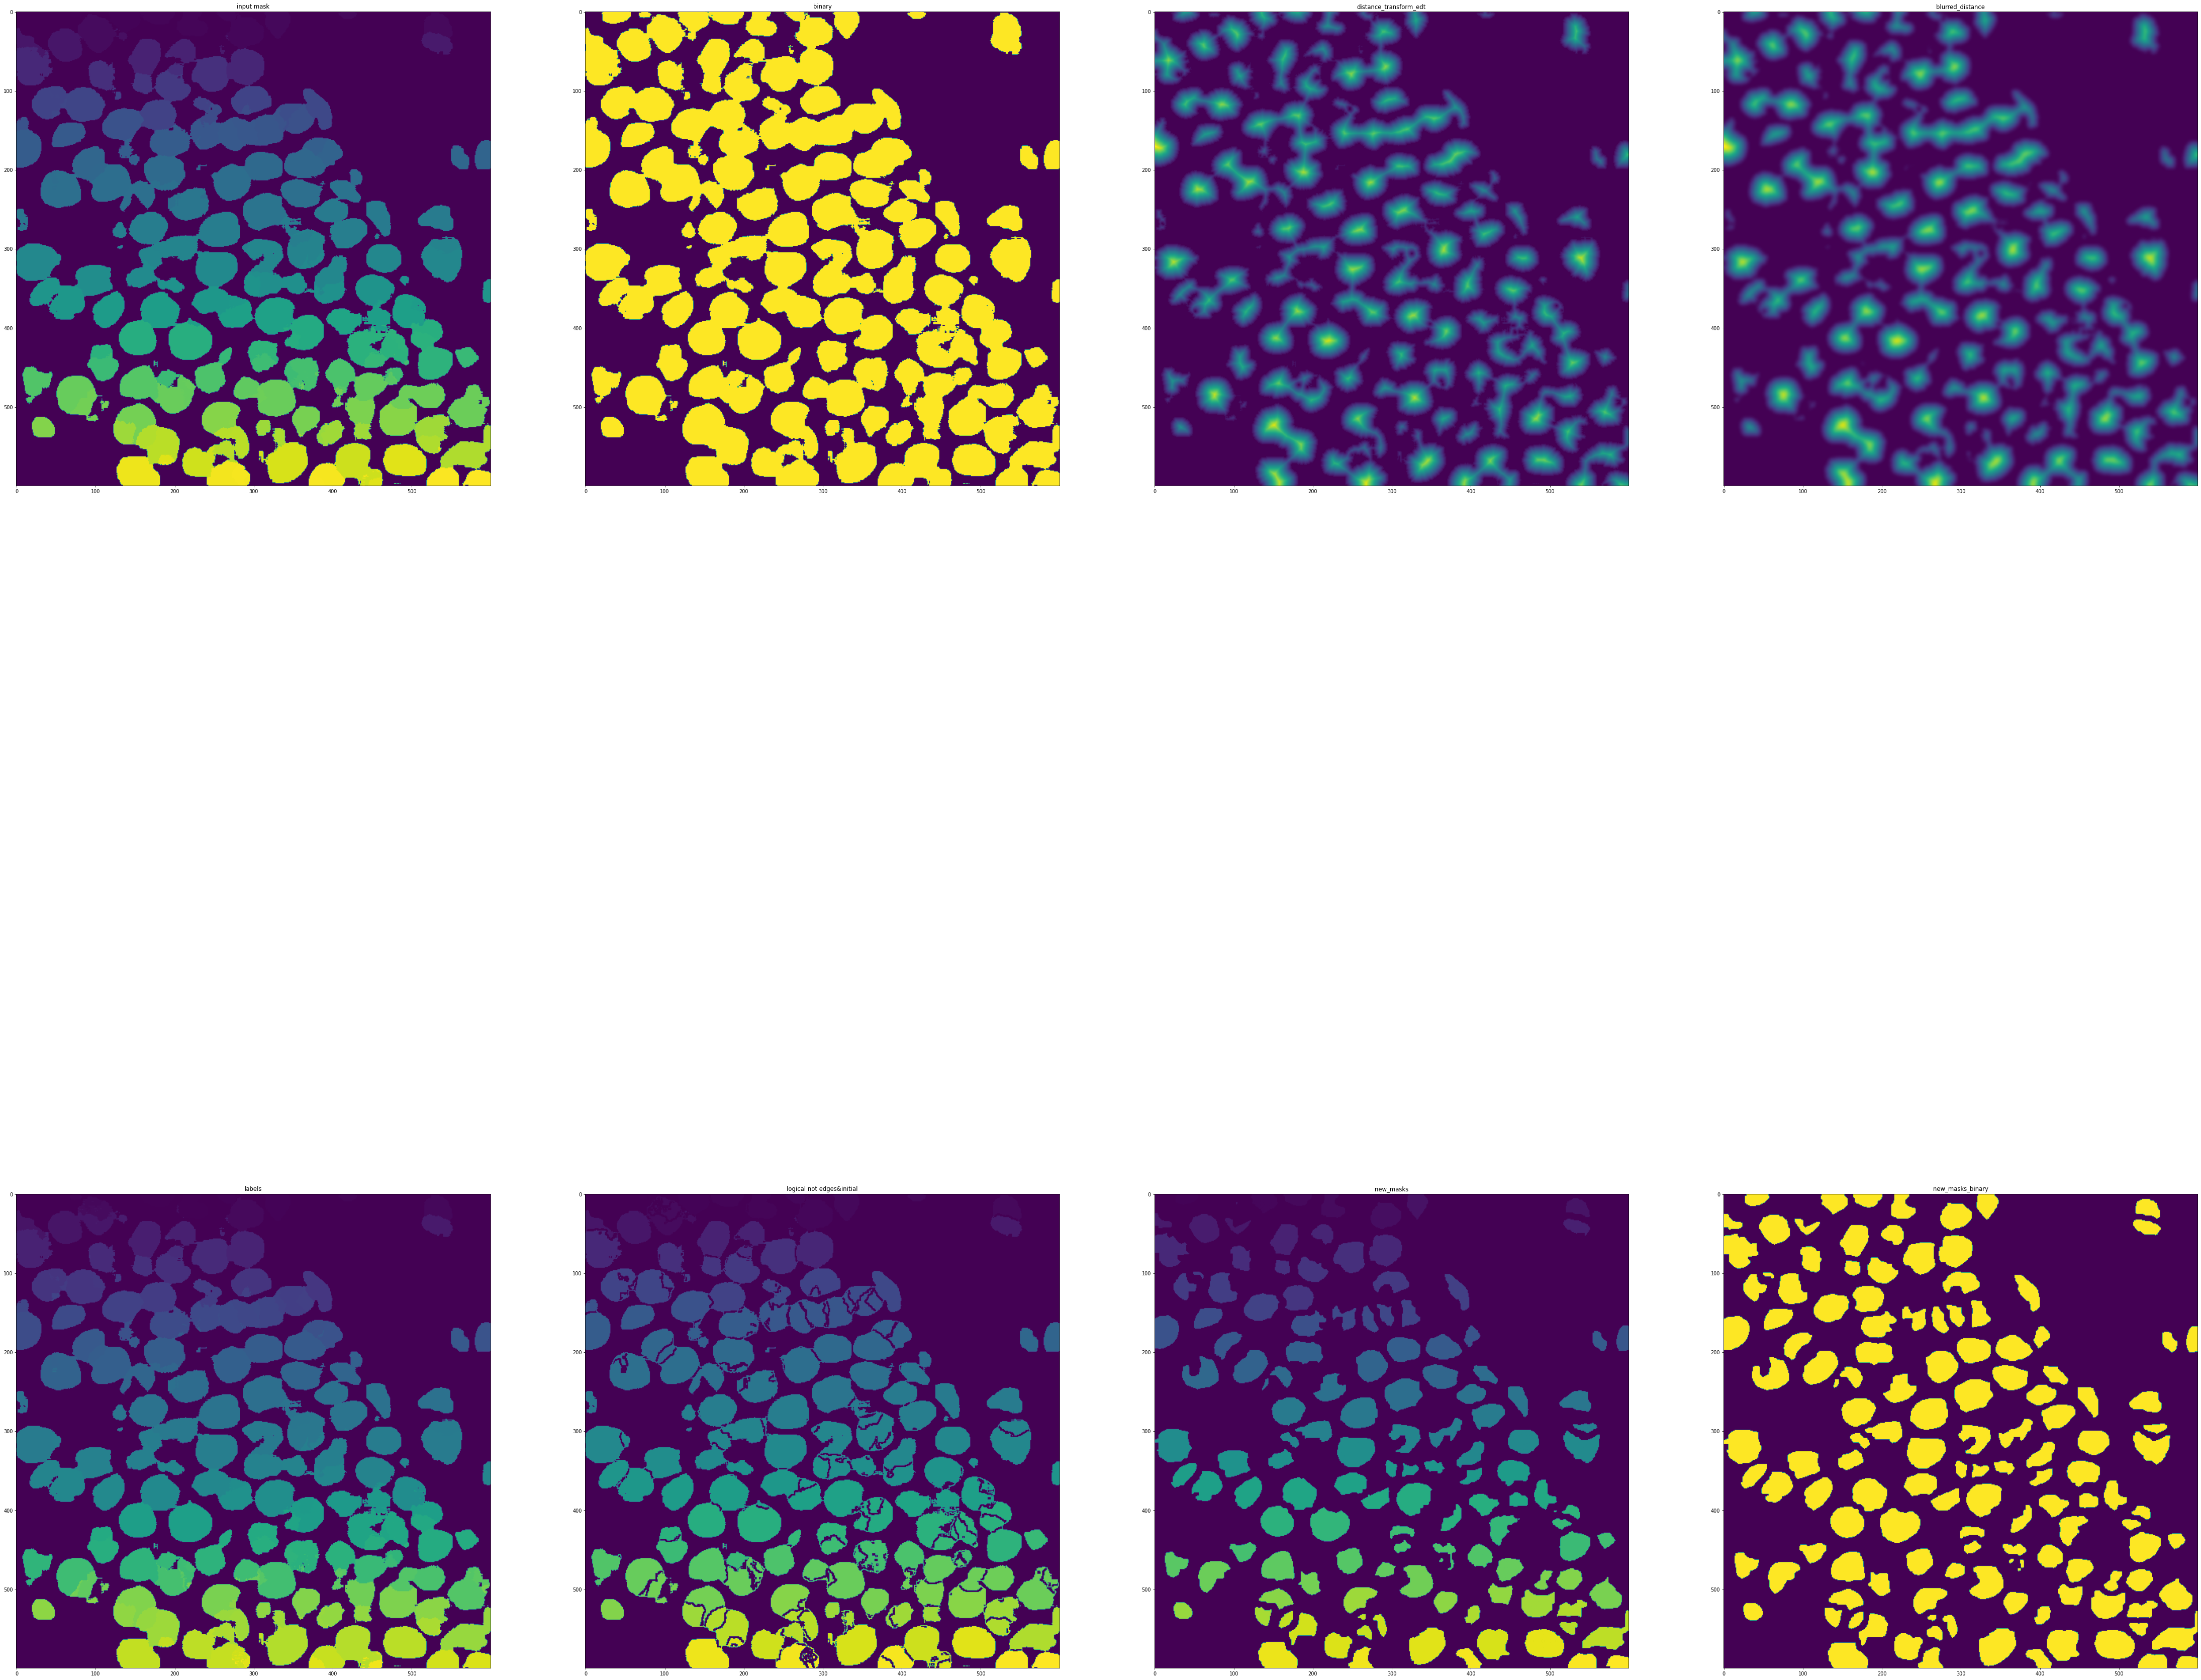

In [ ]:
fig, axs = plt.subplots(2, 4, figsize = (80, 80))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs.flat
sigma = 2
fp = np.ones((3,) * masks_to_2d[0].ndim)
kernel = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (4,4))
kernel_dil = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2,2))
# kernel_close = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2,2))

A = masks_to_2d[100]
_, bin = cv2.threshold(A, 0, 255, cv2.THRESH_BINARY)
distance = ndi.distance_transform_edt(A)
blurred_distance = gaussian(distance, sigma=sigma)
coords = peak_local_max(blurred_distance, footprint=fp, labels=A)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = label(A)
labels = watershed(-blurred_distance, markers, mask=bin)
edges_labels = sobel(labels, cval=0.0)
edges_binary = sobel(bin, cval=0)
edges = np.logical_xor(edges_labels != 0, edges_binary != 0)
almost = np.logical_not(edges) * A
image_erode = cv2.erode(almost, kernel, iterations = 2)

image_dilate = cv2.dilate(image_erode,kernel_dil, iterations = 1)
new_masks = utils.fill_holes_and_remove_small_masks(image_dilate, min_size = 200)
dilate = cv2.dilate(new_masks,kernel_dil, iterations = 1)
open = cv2.morphologyEx(dilate, cv2.MORPH_OPEN, kernel, 1)
_, new_masks_binary =  cv2.threshold(open, 0, 255, cv2.THRESH_BINARY)

ax1.imshow(A)
ax1.set_title('input mask')

ax2.imshow(bin)
ax2.set_title('binary')

ax3.imshow(distance)
ax3.set_title('distance_transform_edt')

ax4.imshow(blurred_distance)
ax4.set_title('blurred_distance')

ax5.imshow(labels)
ax5.set_title('labels')

ax6.imshow(almost)
ax6.set_title('logical not edges&initial')

ax7.imshow(new_masks)
ax7.set_title('new_masks')

ax8.imshow(new_masks_binary)
ax8.set_title('new_masks_binary')


## Z projection

In [ ]:
sigma = 2
fp = np.ones((3,) * masks_to_2d[0].ndim)
kernel = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (4,4))
kernel_dil = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2,2))

segmented_masks = []
for A in masks_to_2d:
  _, bin = cv2.threshold(A, 0, 255, cv2.THRESH_BINARY)
  distance = ndi.distance_transform_edt(A)
  blurred_distance = gaussian(distance, sigma=sigma)
  coords = peak_local_max(blurred_distance, footprint=fp, labels=A)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = label(A)
  labels = watershed(-blurred_distance, markers, mask=bin)
  edges_labels = sobel(labels, cval=0.0)
  edges_binary = sobel(bin, cval=0)
  edges = np.logical_xor(edges_labels != 0, edges_binary != 0)
  almost = np.logical_not(edges) * A
  image_erode = cv2.erode(almost, kernel, iterations = 2)

  image_dilate = cv2.dilate(image_erode,kernel_dil, iterations = 1)
  new_masks = utils.fill_holes_and_remove_small_masks(image_dilate, min_size = 400)
  dilate = cv2.dilate(new_masks,kernel_dil, iterations = 1)
  open = cv2.morphologyEx(dilate, cv2.MORPH_OPEN, kernel, 1)
  _, new_masks_binary =  cv2.threshold(open, 0, 255, cv2.THRESH_BINARY)
  segmented_masks.append(new_masks_binary)

In [ ]:
stack_z = np.stack(segmented_masks, axis = 0)
stack_z = np.moveaxis(stack_z, 0, -1)

stack_z.shape

(600, 600, 176)

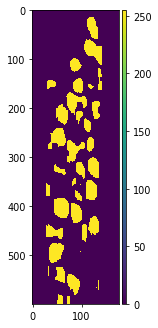

In [ ]:
imshow(stack_z[400, :, :])

In [ ]:
final_dapi_stack= []
for i in range(stack_z.shape[2]):
  img = final_dapi_stack.append(PIL.Image.fromarray(stack_z[:,:,i]))
final_dapi_stack[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/z_watershed_minsize_400.tif', compression="tiff_deflate", save_all=True,
               append_images=final_dapi_stack[1:])

## X projection

In [ ]:
s = 3
kernel_x= cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (5,5))
kernel_dil_x = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2,2))
kernel_x= cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2, 5))

masks_to_2d_x = []
for i in range(stack_z.shape[0]):
  masks_to_2d_x.append(stack_z[i, :, :])

fp = np.ones((3,) * masks_to_2d_x[0].ndim)
masks_seg_x = []
for i in masks_to_2d_x:
  closing_1 = cv2.morphologyEx(i, cv2.MORPH_CLOSE, kernel_x, 10)
  i = closing_1
  _, bin = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY)
  distance = ndi.distance_transform_edt(i)
  blurred_distance = gaussian(distance, sigma=sigma)
  coords = peak_local_max(blurred_distance, footprint=fp, labels=i)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = label(i)
  labels = watershed(-blurred_distance, markers, mask=bin)
  edges_labels = sobel(labels, cval=0.0)
  edges_binary = sobel(bin, cval=0)
  edges = np.logical_xor(edges_labels != 0, edges_binary != 0)
  almost = np.logical_not(edges) * i
  image_erode = cv2.erode(almost, (5, 5), iterations = 5)
  image_dilate = cv2.dilate(image_erode, (3, 3) , iterations = 1)
  new_masks = utils.fill_holes_and_remove_small_masks(image_dilate, min_size = 200)
  _, new_masks_binary =  cv2.threshold(new_masks, 0, 255, cv2.THRESH_BINARY)
  masks_seg_x.append(new_masks_binary)

In [ ]:
stack_x = np.stack(masks_seg_x, axis = 0)
stack_x.shape

(600, 600, 176)

In [ ]:
final_dapi_stack_x = []
for i in range(stack_x.shape[2]):
  img = final_dapi_stack_x.append(PIL.Image.fromarray(stack_x[:,:,i]))
final_dapi_stack_x[0].save('/content/drive/MyDrive/cellpose/Alz/input/raw_stack/z_x_watershed.tif', compression="tiff_deflate", save_all=True,
               append_images=final_dapi_stack_x[1:])

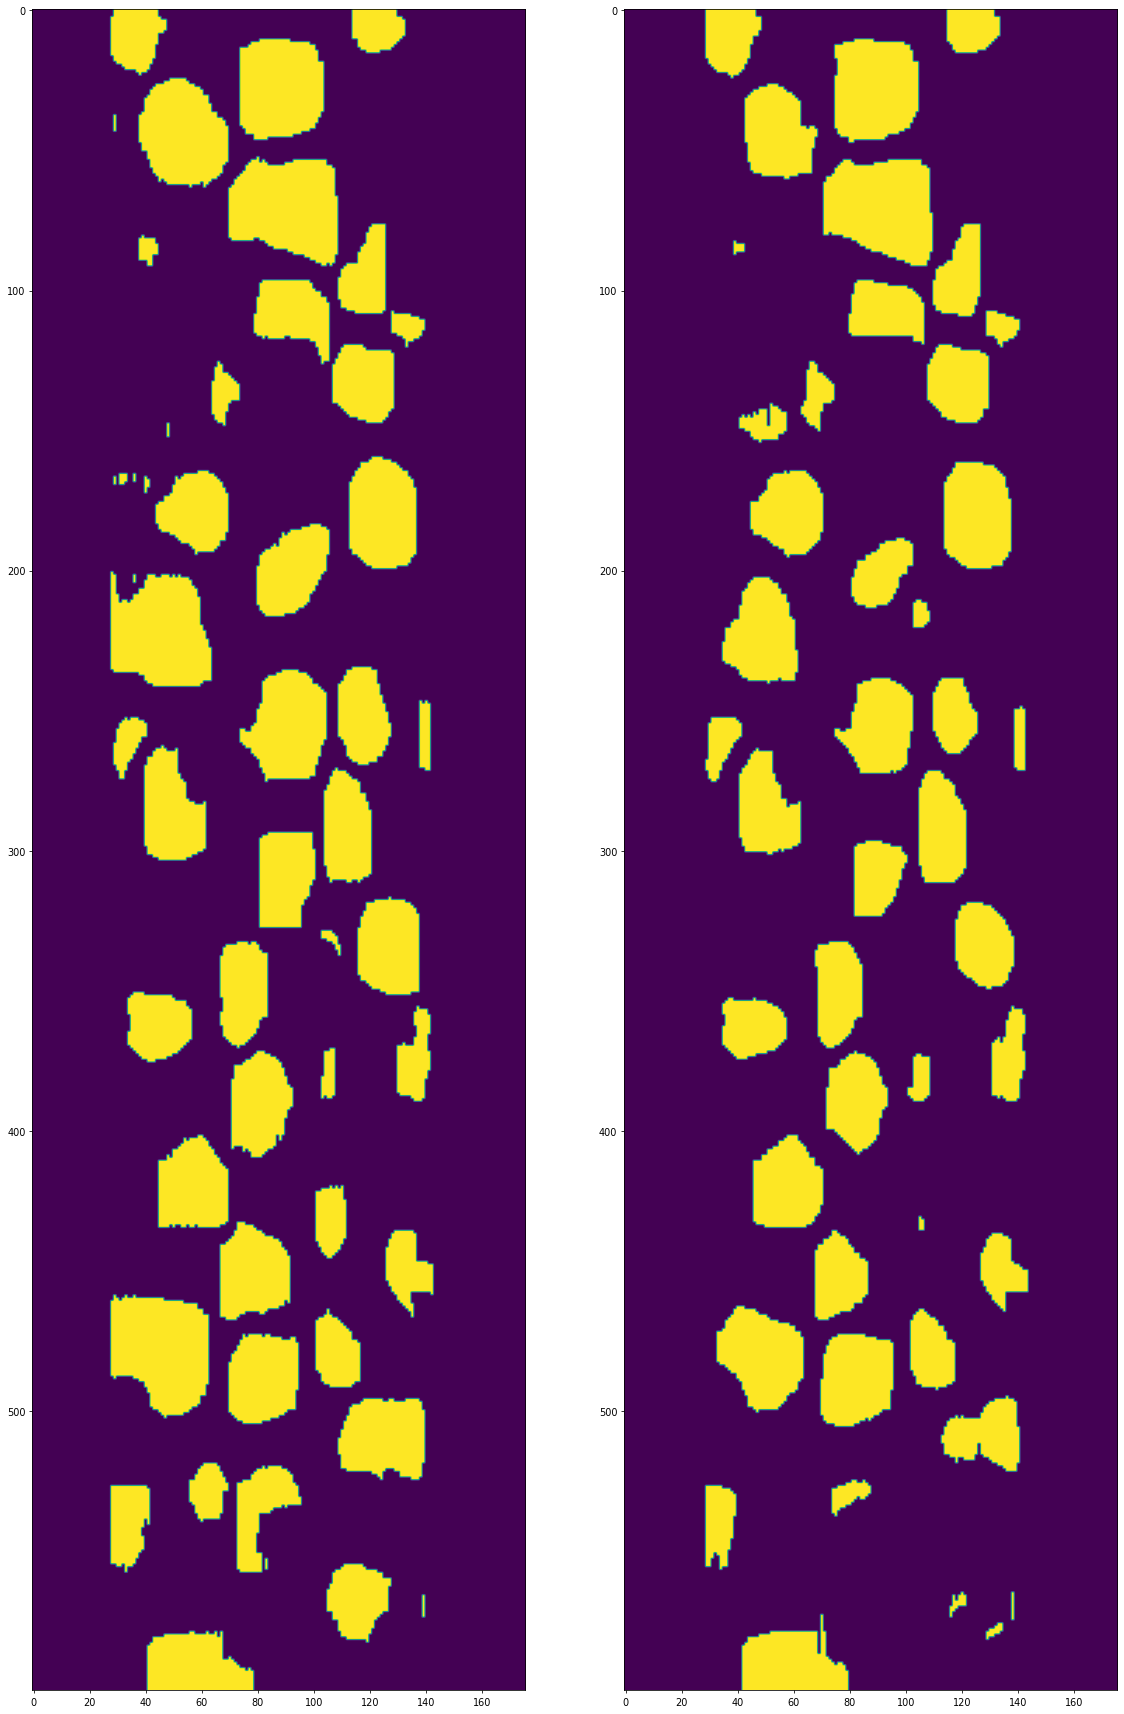

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 40))
ax1.imshow(stack_z[:, 300, :])
ax2.imshow(stack_x[:, 300, :])

In [ ]:
sigma = 3
fp = np.ones((3,) * dapi_masks[0].ndim)
kernel = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (5,5))
kernel_dil = cv2.getStructuringElement (cv2.MORPH_ELLIPSE, (2,2))

dapi_masks_res = []

for i in dapi_masks:
  _, bin = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY)
  distance = ndi.distance_transform_edt(i)
  blurred_distance = gaussian(distance, sigma=sigma)
  coords = peak_local_max(blurred_distance, footprint=fp, labels=i)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = label(i)
  labels = watershed(-blurred_distance, markers, mask=bin)
  edges_labels = sobel(labels, cval=0.0)
  edges_binary = sobel(bin, cval=0)
  edges = np.logical_xor(edges_labels != 0, edges_binary != 0)
  almost = np.logical_not(edges) * i
  image_erode = cv2.erode(almost, kernel, iterations = 2)
  image_dilate = cv2.dilate(image_erode,kernel_dil, iterations = 2)
  new_masks = utils.fill_holes_and_remove_small_masks(image_dilate, min_size = 300)
  _, new_masks_binary =  cv2.threshold(new_masks, 0, 255, cv2.THRESH_BINARY)
  dapi_masks_res.append(new_masks_binary)

In [ ]:
# !pip install -q condacolab
import condacolab
condacolab.install()
import condacolab
# condacolab.check()
# !mamba install pyimagej openjdk=11
# !wget https://downloads.imagej.net/fiji/latest/fiji-linux64.zip > /dev/null && unzip fiji-linux64.zip > /dev/null
# !rm fiji-linux64.zip

import os
os.environ['JAVA_HOME']='/usr/local'

import imagej
ij = imagej.init("/content/Fiji.app")
print(ij.getVersion())

‚ú®üç∞‚ú® Everything looks OK!
2.14.0/1.54f


In [ ]:
img = ij.io().open('/content/drive/MyDrive/z_x_30.tif')

In [ ]:
ij.py.run_plugin("3D Objects Counter")


[java.lang.Enum.toString] You need to open an image first.[java.lang.Enum.toString] 


java.lang.RuntimeException: ignored